# Example of downsampling and interpolating data with `romSpline`

In [1]:
# Import necessary modules
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Uncomment next two lines if romSpline is not in your PYTHONPATH
# import sys
# sys.path.append(<path to romSpline>)

import romSpline

In [2]:
# Make up some test data to show how to use the code.
x = np.linspace(-1, 1, 100001)

def f(x):
    return 100.*( (1.+x)*np.sin(5.*(x-0.2)**2) + np.exp(-(x-0.5)**2/2./0.01)*np.sin(100*x) )

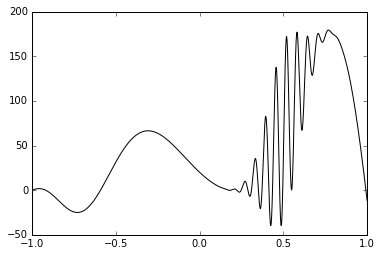

In [3]:
# Plot the test data to see how it looks.
plt.plot(x, f(x), 'k-');

### Building a reduced-order spline

In [4]:
# Create a reduced-order spline by making an instance of the ReducedOrderSpline class.
spline = romSpline.ReducedOrderSpline(x, f(x), verbose=True)

# Additional options include:
#     deg -- degree of interpolating spline polynomials (default is 5)
#     tol -- tolerance of greedy algorithm (default is 1e-6)
#     rel -- use relative errors if True (default is False)


Size 	Error
7 	109.923909402
8 	200.735648108
9 	2378.48939455
10 	1084.67620686
11 	722.724632227
12 	491.921200922
13 	658.498153554
14 	345.494055596
15 	289.79994798
16 	400.056305789
17 	480.881557483
18 	473.89818132
19 	339.760656984
20 	312.348775991
21 	298.402466704
22 	293.191345999
23 	221.48957756
24 	214.196073872
25 	272.707510515
26 	207.458156046
27 	160.726679878
28 	139.574873685
29 	66.6195064279
30 	51.95872435
31 	40.2956373144
32 	30.4583285679
33 	26.2806404373
34 	23.7367034642
35 	18.8089851872
36 	17.7907446738
37 	13.506634482
38 	11.6732677074
39 	6.88675206695
40 	6.86892121717
41 	5.09704029615
42 	4.89234654309
43 	3.26935478145
44 	3.11819667034
45 	2.63016942199
46 	2.54223206129
47 	2.53868769459
48 	2.52612135534
49 	1.99661662702
50 	1.98323345886
51 	1.42355380649
52 	0.921708051205
53 	0.896236023613
54 	0.588439577505
55 	0.44610967306
56 	0.413508450138
57 	0.880269498547
58 	0.559703265237
59 	0.454164087744
60 	0.384660270789
61 	0.3258219486

In [5]:
# Because data, namely, x and f(x), are given then the class goes ahead and builds the
# reduced-order spline via a greedy algorithm. The number of optimal points and the 
# resulting compression factor are:
print "Number of optimal points:", spline.size
print "Compression factor:", spline.compression

Number of optimal points: 447
Compression factor: 223.715883669


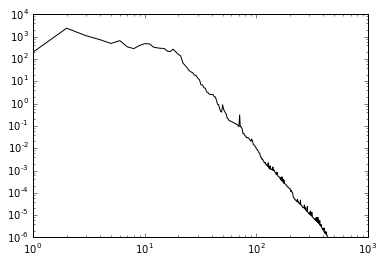

In [6]:
# Plot the max L-infinity errors that were found in building the "optimal" spline.
# Notice that the decay is polynomial (power is deg+1) and not exponential. 
# This is because the spline is only smooth to the degree of the polynomial used. 
# For this reason, it's good not to set the tolerance too high (e.g., numerical round-off)
# as the time to generate spline might be impractically long.
plt.loglog(spline.errors, 'k-');

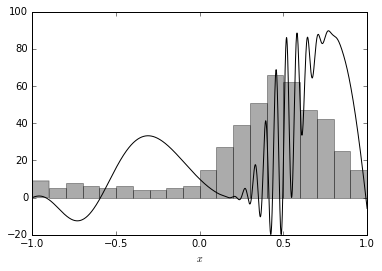

In [7]:
# The distribution of the "optimal" points (called "X") is not uniform. Generally speaking, the
# density of the points is highest around the more variable data.
plt.hist(spline.X, 20, color='k', alpha=0.33)
plt.plot(x, f(x)/2., 'k-')
plt.xlabel('$x$');

In [8]:
# To evaluate the spline let's first create an array of new samples
import random
xx = np.sort([random.uniform(x.min(), x.max()) for ii in range(10000)])

# Then you can use "eval" to evaluate the spline
y1 = spline.eval(xx)

# ...or do the following:
y2 = spline(xx)

# These are equivalent -- their difference is an array of zeros
print np.all(np.abs(y1-y2) == 0.)

True


In [9]:
# You can write the relevant spline interpolant data to HDF5 format
spline.write('test1.h5')

# or you can pass in an HDF5 file descriptor like this
import h5py
fp = h5py.File('test1a.h5', 'w')
spline.write(fp)
fp.close()

# or you can pass in an HDF5 file group descriptor (if you have 
# multiple reduced-order spline interpolants data to export) like this
fp = h5py.File('test1b.h5', 'w')
test = fp.create_group('test')
spline.write(test)
fp.close()

# or to text format (this creates a directory with the given filename
# and has a number of text files with the relevant data)
spline.write('test1.txt')

# There is also a keyword option called "slim" (default is False) that
# writes only the reduced data as well as deg and tol for 
# reconstructing the reduced-order spline interpolant. In particular,
# the array of greedy errors is not written to file when slim=True.

In [10]:
# Next, let's pretend you've already saved the reduced-order spline data to file 
# and want to evaluate the interpolant given only a previously created data file. In this case, do the following:
s = romSpline.ReducedOrderSpline()
s.read('test1.h5')

In [11]:
# You can check that data was loaded by evaluating the spline at the xx samples
s.eval(xx)

array([  8.43573596e-03,   2.27773001e-02,   2.71346369e-02, ...,
        -8.73697826e+00,  -9.65244020e+00,  -1.10398888e+01])

In [12]:
# One doesn't need to create an instance of the ReducedOrderSpline class 
# to import the data for a previously generated reduced-order spline
# if one uses the readSpline function.
s_h5 = romSpline.readSpline('test1.h5')
print s_h5(xx)

s_txt = romSpline.readSpline('test1.txt')
print s_txt(xx)

[  8.43573596e-03   2.27773001e-02   2.71346369e-02 ...,  -8.73697826e+00
  -9.65244020e+00  -1.10398888e+01]
[  8.43573596e-03   2.27773001e-02   2.71346369e-02 ...,  -8.73697826e+00
  -9.65244020e+00  -1.10398888e+01]


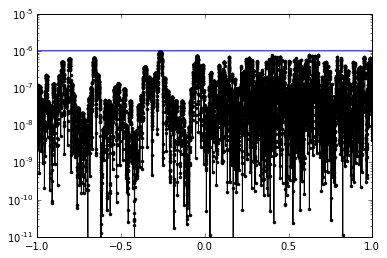

In [13]:
# Let's plot the difference bewteen the original function and the spline at xx.
# Also plotted in blue is the default tolerance (1e-6) used by the greedy algorithm
plt.semilogy(xx, np.abs(f(xx)-s(xx)), 'k.-', xx, 1e-6*np.ones(xx.size), 'b-');
plt.ylim(1e-11, 1e-5);

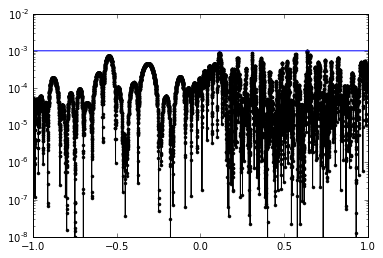

In [14]:
# We can rerun the greedy algorithm to make a spline with a different tolerance, for example.
# Using the same object "spline" (or you can create a new one), we run the "greedy" method
spline.greedy(x, f(x), tol=1e-3)

# ...and plot the spline errors at the xx samples like we did earlier
plt.semilogy(xx, np.abs(f(xx)-spline.eval(xx)), 'k.-', xx, 1e-3*np.ones(xx.size), 'b-');
plt.ylim(1e-8, 1e-2);

In [15]:
# And you can write this spline data to file, too
spline.write('test2.h5')
spline.write('test2.txt')

The compression factor is: 1587.31746032
The (relative) tolerance requested is 0.001
The (absolute) tolerance used is: 0.179373340905 0.179373340905


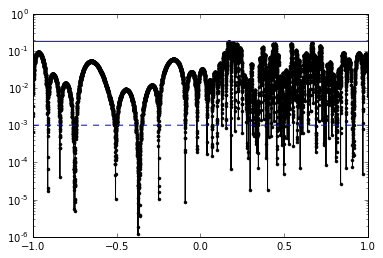

In [16]:
# In addition, you can build a reduced-order spline where the tolerance is relative 
# to the maximum of the absolute value of the data by using the rel option:
spline.greedy(x, f(x), tol=1e-3, rel=True)

print "The compression factor is:", spline.compression
print "The (relative) tolerance requested is", spline._tol
print "The (absolute) tolerance used is:", spline.tol, spline._tol * np.max(np.abs(f(x)))

plt.semilogy(xx, np.abs(f(xx)-spline.eval(xx)), 'k.-', 
            xx, spline._tol*np.ones(xx.size), 'b--',
            xx, spline.tol*np.ones(xx.size), 'b-'
);

### Reduced-order splines and derivatives

In [17]:
# You can compute derivatives of the interpolated function directly. 
# For the first derivative just type:
spline = romSpline.ReducedOrderSpline(x, f(x), tol=1e-3)
spline.eval(x, dx=1)

array([   79.34054226,    79.31150202,    79.28244828, ..., -1603.17786564,
       -1603.2364301 , -1603.29495813])

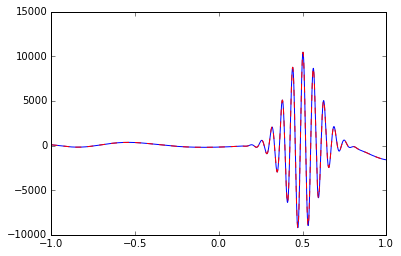

In [18]:
# Let's compare this to building a spline of the analytic derivative:
def dfdx(x):
    """Analytic derivative of f(x) test data"""
    a = 10.*(-0.2+x)*(1.+x)*np.cos(5.*(-0.2 + x)**2)
    b = 100.*np.exp(-50.*(-0.5+x)**2)*np.cos(100.*x)
    c = np.sin(5.*(-0.2+x)**2)
    d = -100.*np.exp(-50.*(-0.5+x)**2)*(-0.5+x)*np.sin(100.*x)
    return 100.*(a+b+c+d)

# Reduced-order spline of the analytic derivative:
dspline = romSpline.ReducedOrderSpline(x, dfdx(x), tol=1e-3)

# Plot the two splines. By the eyeball norm they both agree...
plt.plot(x, spline(x, dx=1), 'b-');
plt.plot(x, dspline(x), 'r--');

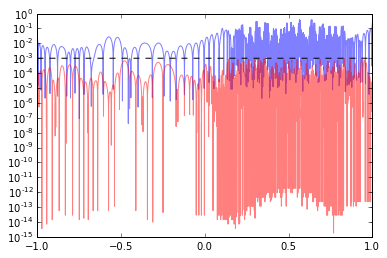

In [19]:
#...but building the reduced-order spline from the analytic derivative
# is more accurate than computing the derivative of the reduced-order spline
y = f(x)
y1 = dfdx(x)  # Compute derivative analytically

plt.semilogy(x, np.abs(spline(x, dx=1)-y1), 'b-', alpha=0.5);
plt.semilogy(x, np.abs(dspline(x)-y1), 'r-', alpha=0.5);
plt.semilogy(x, dspline.tol*np.ones(x.size), 'k--');

In [20]:
# If we didn't have access to the analytical derivative of the data
# then we can use finite-difference differentiation to numerically
# compute the derivative and build a spline for that data.
Df = romSpline.D(f(x), x)  # Default options: dx=1, order=4
Dspline = romSpline.ReducedOrderSpline(x, Df, tol=1e-3)
print "Size of spline =", Dspline.size
print "Compression factor =", Dspline.compression

# Notice that more points are needed for the derivative. This happens
# because we are imposing a tol on the *absolute* error of 1e-3 here
# and the derivative is large for some values of x.

Size of spline = 355
Compression factor = 281.692957746


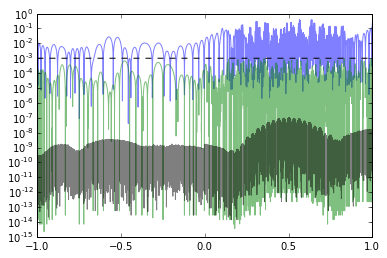

In [21]:
# The spline built from the numerical derivative of the data is
# also a bit better than evaluating the derivative of the spline 
# built from the original data and taking its derivative:
plt.semilogy(x, np.abs(spline(x, dx=1)-y1), 'b-', alpha=0.5);
plt.semilogy(x, np.abs(Dspline(x)-Df), 'g-', alpha=0.5);
plt.semilogy(x, Dspline.tol*np.ones(x.size), 'k--');

# For comparison, shown in black is the difference between the 
# numerically and analytically computed derivatives of the data.
plt.semilogy(x, np.abs(Df-dfdx(x)), 'k-', alpha=0.5);